Pakcage Intallation and load variables

1. We first install the cclust_package and then load the learned embeddings from both domains (RNA and ATAC), together with the corresponding optimal transport (OT) map.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/franrole/cclust_package.git

Cloning into 'cclust_package'...
remote: Enumerating objects: 1634, done.
remote: Total 1634 (delta 0), reused 0 (delta 0), pack-reused 1634 (from 1)
Receiving objects: 100% (1634/1634), 11.12 MiB | 40.22 MiB/s, done.
Resolving deltas: 100% (1024/1024), done.


In [ ]:
cd /content/cclust_package

/content/cclust_package


In [ ]:
!pip install .


Processing /content/cclust_package
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for coclust: filename=coclust-0.2.1-py3-none-any.whl size=35980 sha256=cdb76f21e08ea911d57f3c75bc18bfdb056204a3f9757d126042f0d92f994685
  Stored in directory: /tmp/pip-ephem-wheel-cache-awm83bar/wheels/c7/21/32/ceb28387c8430d3b3694d6774a6dd69647fef198ff37619f24
Successfully built coclust


In [ ]:
pip install igraph louvain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 69.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for louvain: filename=louvain-0.8.2-cp312-cp312-linux_x86_64.whl size=971948 sha256=6c598d870ef389f6c2e3359cb8a5060da959021e8eee096c0aff64b89df29d58
  Stored in directory: /root/.cache/pip/wheels/40/de/2b/bb7ed19d84727f9f299f20cd34c42bba9c8bef7d83d2255c86
Successfully built louvain


In [ ]:
pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 123.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
pip install scipy==1.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 31.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2


In [ ]:
import Grotia_utils
importlib.reload(Grotia_utils)
from Grotia_utils import (
    prune_small_clusters,
    reconstruction_error_pruned,
    load_results,
    hyperparameter_search_cluster_count,
    run_coclust_full_pipeline,
    cluster_purity,
    grid_cluster_louvain
)


In [ ]:

# Example usage:
mapped_K1, mapped_K2, ot_plan, alpha, beta = load_results(
    path_mappedK1="/content/drive/MyDrive/mappedK1.npy",
    path_mappedK2="/content/drive/MyDrive/mappedK2.npy",
    path_otplan="/content/drive/MyDrive/ot_plan.npy",
    path_alpha="/content/drive/MyDrive/alpha.npy",
    path_beta="/content/drive/MyDrive/beta.npy"
)

print("Loaded shapes:")
print("  mapped_K1:", mapped_K1.shape)
print("  mapped_K2:", mapped_K2.shape)
print("  ot_plan:", ot_plan.shape)
print("  alpha:", alpha.shape)
print("  beta:", beta.shape)


Loaded shapes:
  mapped_K1: (9378, 8)
  mapped_K2: (9378, 8)
  ot_plan: (9378, 9378)
  alpha: (9378, 8)
  beta: (9378, 8)


We loop over a range of cluster numbers, fit the co-clustering model, prune small clusters, and compute the reconstruction error, which measures how well the block-constant approximation induced by the row and column cluster assignments preserves the original data structure.

The optimal cluster number is chosen using the elbow method, yielding 14 clusters in our setting.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


# Example usage:
n_cluster_candidates = range(8, 21)  # or any other range
ot_plan_array = np.asarray(ot_plan)

cluster_values, errors = hyperparameter_search_cluster_count(
    ot_plan_array,
    min_size=0,
    cluster_range=n_cluster_candidates
)

# Plot the results
plt.figure(figsize=(6,4))
plt.plot(cluster_values, errors, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Reconstruction Error (Frobenius norm)")
plt.title("Hyperparameter Tuning of n_clusters")
plt.show()

# Find the best k (smallest reconstruction error)
best_k = cluster_values[np.argmin(errors)]
print("Best number of clusters based on the minimum reconstruction error:", best_k)


NameError: name 'ot_plan' is not defined

We now plot the 2d embedding with umap and

In [ ]:
import muon as mu
mdata = mu.read_h5mu("/content/drive/MyDrive/pbmc10X.h5mu.gz")

sc.pp.filter_cells(mdata["rna"], min_genes=100)
sc.pp.filter_genes(mdata["rna"], min_cells=20)

sc.pp.filter_cells(mdata["atac"], min_genes=100)
# we're actually filtering peaks here
sc.pp.filter_genes(mdata["atac"], min_cells=20)
mdata.update()
import scanpy as sc
import numpy as np
from anndata import AnnData

# Suppose:
#  mapped_K1 shape = (N1, p)  for RNA cells
#  mapped_K2 shape = (N2, p)  for ATAC cells

# 1) RNA domain
adata_rna = mdata["rna"].copy()  # shape (N1, G)
N1 = adata_rna.n_obs
G = adata_rna.n_vars

# 2) ATAC domain: create minimal placeholder
# We'll fill X with zeros, shape (N2, G).
# So domain2 cells have 0 expression for these G genes.
N2 = mapped_K2.shape[0]
X_atac_placeholder = np.zeros((N2, G), dtype="float32")

adata_atac = AnnData(
    X=X_atac_placeholder,
    obs={"domain": ["atac"] * N2},     # label domain in obs
    var=adata_rna.var.copy()          # same var names as RNA, or just copy
)
if "domain" not in adata_rna.obs.columns:
    adata_rna.obs["domain"] = "rna"
adata_combined = sc.concat(
    [adata_rna, adata_atac],
    join="outer",      # ensures union of var names if needed
    label="domain_join",  # or no label
    keys=["rna","atac"]
)

joint_labels_true = np.concatenate([mdata['rna'].obs['celltype'], mdata['atac'].obs['celltype']], axis=0)


# Alternatively:
# adata_combined = anndata.concat([adata_rna, adata_atac], ...)
#
# Now shape = (N1 + N2, G)
mapped_concat = np.concatenate([mapped_K1, mapped_K2], axis=0)  # shape (N1+N2, p)
adata_combined.obsm["X_integrated"] = mapped_concat
sc.pp.neighbors(
    adata_combined,
    use_rep="X_integrated",  # the integrated embedding

)

sc.tl.umap(adata_combined, random_state=0)


/usr/local/lib/python3.12/dist-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


we then run_coclust_full_pipeline fits spectral co-clustering (CoclustSpecMod) on the OT plan—optionally choosing the cluster number (14 in our case), builds a joint RNA+ATAC embedding AnnData with neighbors/UMAP, and reports clustering metrics (ARI/NMI/purity/silhouette) without any pruning.

[INFO] Rows=9378, Cols=9378, Embedding dims: K1=8, K2=8

[FINAL] Fitting CoclustSpecMod with n_clusters=14


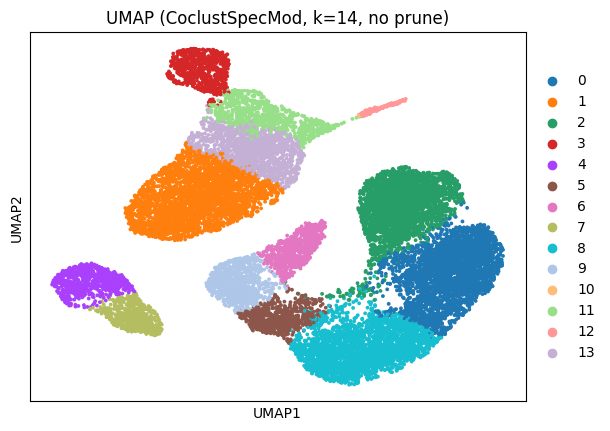


[Metrics | full set]
  ARI:        0.787
  NMI:        0.833
  Purity:     0.871
  Silhouette: 0.410


In [ ]:


out = run_coclust_full_pipeline(
    ot_plan=ot_plan,
    mapped_K1=mapped_K1,
    mapped_K2=mapped_K2,
    n_clusters=14,                      # or cluster_grid=range(8,21) to auto-pick k
    metric_labels_true=joint_labels_true,  # optional (length R+C, rows then cols)
    cluster_grid=None,
    neighbors_k=15,
    do_umap=True,
    random_state=0
)

# adata_full     = out["adata"]
# joint_labels   = out["joint_labels"]
# ari, nmi       = out["ari"], out["nmi"]
# purity, sil    = out["purity"], out["silhouette"]
# n_used         = out["n_clusters_used"]
# grid_df        = out["results_grid"]


For benchmarking, we run the Louvain algorithm with a grid search over its resolution parameter and benchmark its clustering performance.


Running Louvain with resolution=0.1 ...
  -> Clusters: 7 | ARI 0.635 | NMI 0.788 | Purity 0.642 | Silhouette 0.457

Running Louvain with resolution=0.3 ...
  -> Clusters: 10 | ARI 0.766 | NMI 0.823 | Purity 0.815 | Silhouette 0.436

Running Louvain with resolution=0.4 ...
  -> Clusters: 10 | ARI 0.776 | NMI 0.831 | Purity 0.820 | Silhouette 0.438

Running Louvain with resolution=0.5 ...
  -> Clusters: 14 | ARI 0.717 | NMI 0.826 | Purity 0.893 | Silhouette 0.361

Running Louvain with resolution=0.6 ...
  -> Clusters: 14 | ARI 0.712 | NMI 0.822 | Purity 0.891 | Silhouette 0.361

Running Louvain with resolution=1.0 ...
  -> Clusters: 18 | ARI 0.645 | NMI 0.796 | Purity 0.899 | Silhouette 0.316

Running Louvain with resolution=1.5 ...
  -> Clusters: 22 | ARI 0.470 | NMI 0.750 | Purity 0.896 | Silhouette 0.254


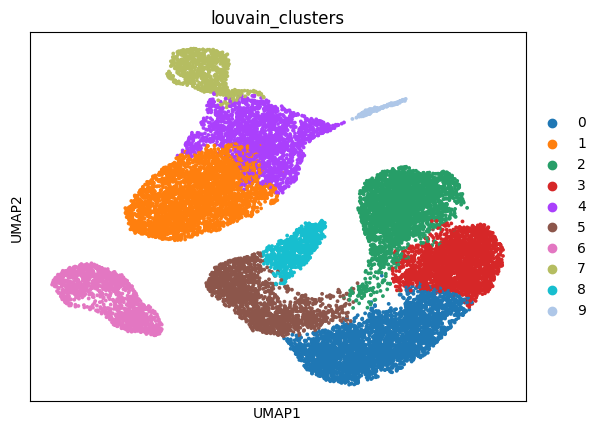


Summary of all resolutions:
Resolution=0.1, Clusters=7, ARI=0.635, NMI=0.788, Purity=0.642, Silhouette=0.457, Composite=-0.526
Resolution=0.3, Clusters=10, ARI=0.766, NMI=0.823, Purity=0.815, Silhouette=0.436, Composite=0.564
Resolution=0.4, Clusters=10, ARI=0.776, NMI=0.831, Purity=0.820, Silhouette=0.438, Composite=0.679
Resolution=0.5, Clusters=14, ARI=0.717, NMI=0.826, Purity=0.893, Silhouette=0.361, Composite=0.415
Resolution=0.6, Clusters=14, ARI=0.712, NMI=0.822, Purity=0.891, Silhouette=0.361, Composite=0.360
Resolution=1.0, Clusters=18, ARI=0.645, NMI=0.796, Purity=0.899, Silhouette=0.316, Composite=-0.190
Resolution=1.5, Clusters=22, ARI=0.470, NMI=0.750, Purity=0.896, Silhouette=0.254, Composite=-1.302

Best resolution by Composite score: 0.4


In [ ]:

results_df, best_res, best_labels = grid_cluster_louvain(
    adata_combined,
    true_labels=joint_labels_true,
    resolutions=(0.1, 0.3, 0.4, 0.5, 0.6, 1.0, 1.5),
    use_rep="X_integrated",
    neighbors_k=15,
    key_added="louvain_clusters",
    plot_umap=True,
    random_state=0,
)


Finally, we plot the resulting embeddings and clustering assignments.

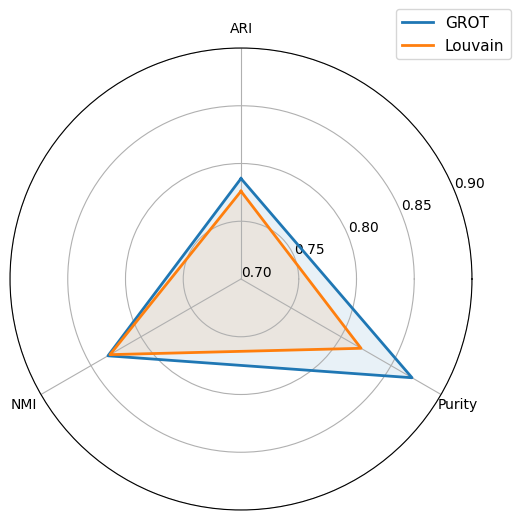

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

######################
# 1) DATA
######################
labels = ["ARI", "NMI", "Purity"]

# GROT
grot_scores = [0.787, 0.833, 0.871]

# Louvain (resolution=0.6)
louvain_scores = [0.776, 0.831, 0.820]

methods = {
    "GROT": grot_scores,
    "Louvain": louvain_scores
}

######################
# 2) DEFINE ANGLES
######################
# We want ARI at the top (90°), NMI at 210°, Purity at 330°,
# each ~120° apart to form a symmetrical triangle.
base_angles = np.array([
    np.pi / 2,       # 90 deg  (ARI)
    7 * np.pi / 6,   # 210 deg (NMI)
    11 * np.pi / 6   # 330 deg (Purity)
])
# Repeat the first angle at the end to close the polygon
angles = np.concatenate((base_angles, [base_angles[0]]))

def close_loop(scores):
    """Repeat the first score so the polygon closes."""
    return np.concatenate((scores, [scores[0]]))

######################
# 3) CREATE FIGURE
######################
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

# Plot each method
for method_name, scores in methods.items():
    data = close_loop(scores)
    ax.plot(angles, data, label=method_name, linewidth=2)
    ax.fill(angles, data, alpha=0.1)

######################
# 4) SET TICKS & LABELS
######################
# Match angles (excluding the repeated last one)
ax.set_xticks(base_angles)
ax.set_xticklabels(labels)

######################
# 5) CUSTOMIZE RADIAL AXIS
######################
ax.set_ylim(0.70, 0.90)
y_ticks = [0.70, 0.75, 0.80, 0.85, 0.90]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{tick:.2f}" for tick in y_ticks])

# ax.set_title("Radar Plot: GROT vs. Louvain", pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1),fontsize=11)

######################
# 6) SAVE AS PDF
######################
plt.savefig("radar_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
# ✅ Save AnnData object (compressed HDF5 format)
adata_combined.write("adata_pbmc_1_combined.h5ad")
